In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zlib import crc32

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('sonar.all-data.csv', header=None)

### Cursory EDA

In [3]:
df.describe() #no missing vals
#df.info()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [4]:
df[60].value_counts() #more or less balanced

M    111
R     97
Name: 60, dtype: int64

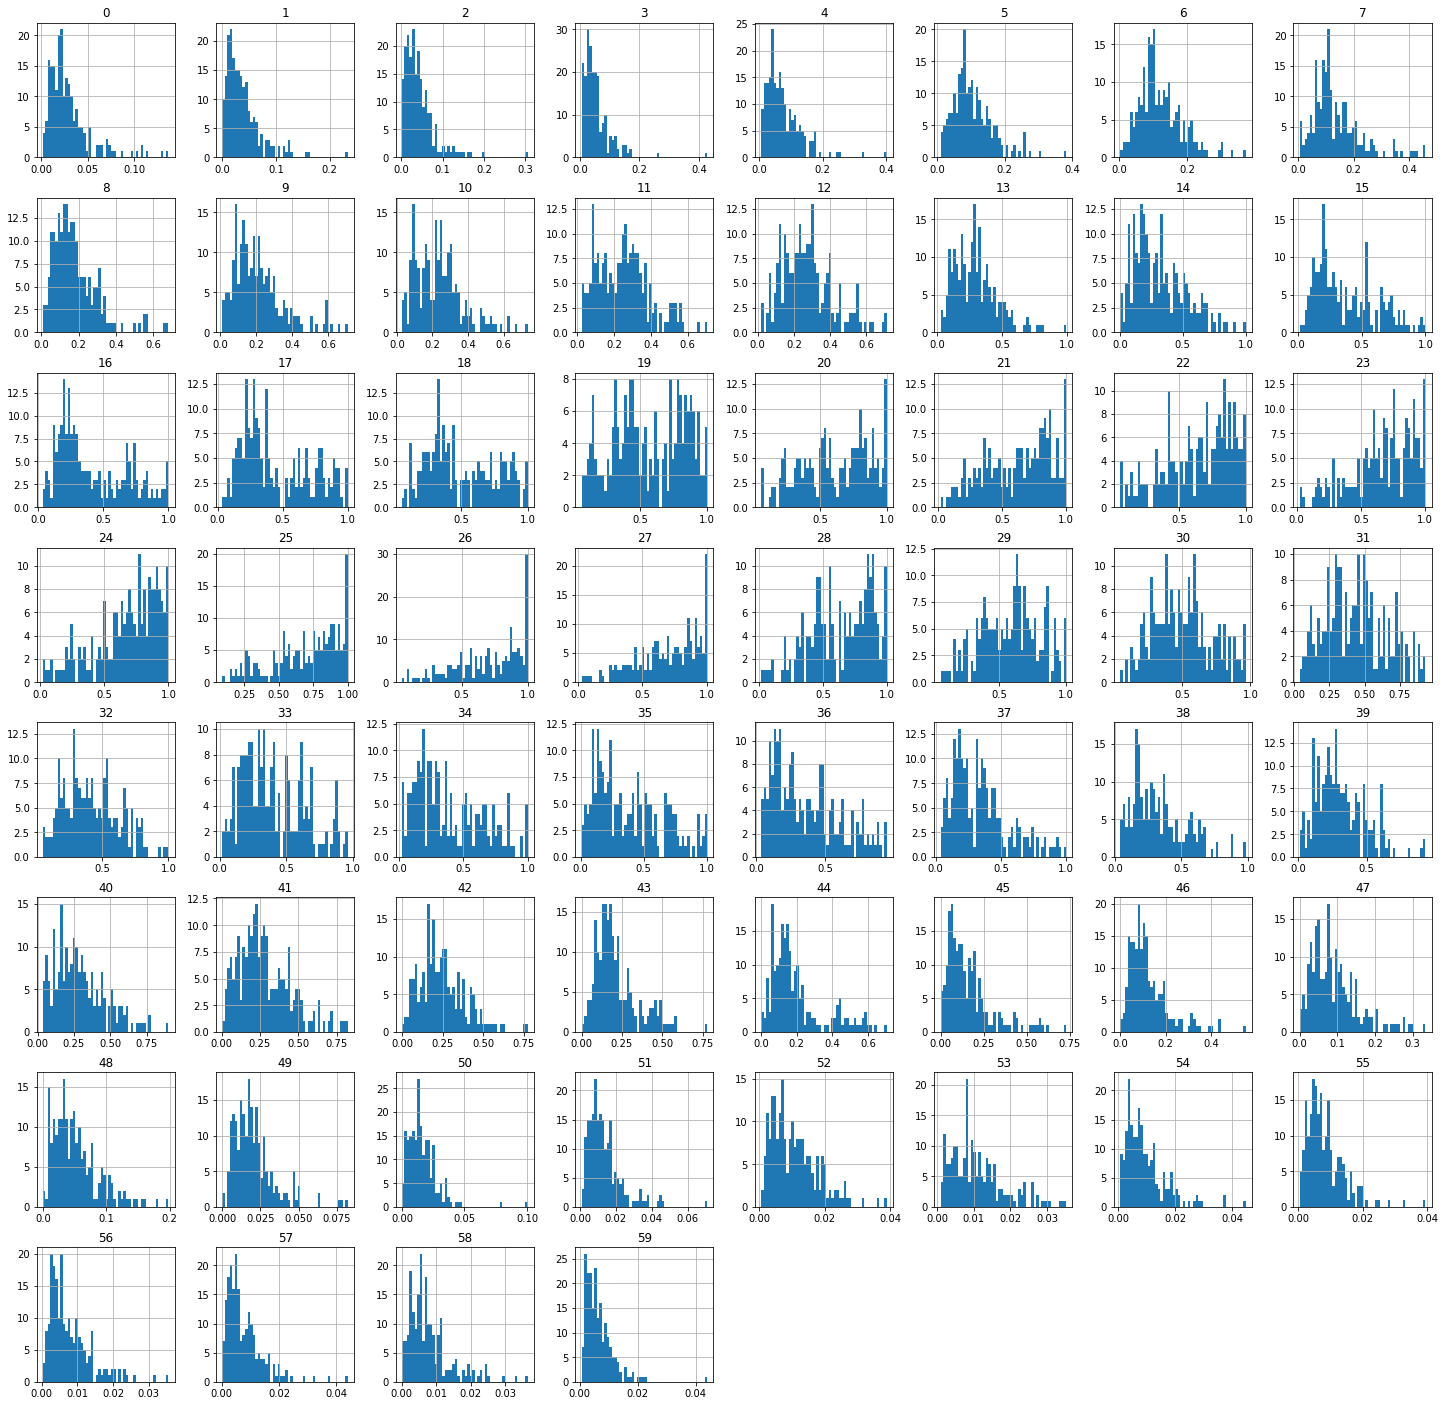

In [5]:
df.hist(bins=50, figsize=(25,25))
plt.show() #some values appear potentially capped at 1

### Hashed train/test split

In [6]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [7]:
df_with_id = df.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "index")

In [8]:
X_train, y_train, X_test, y_test = train_set.iloc[:,:61], train_set.iloc[:,61], \
                                    test_set.iloc[:,:61], test_set.iloc[:,61]

In [9]:
X_train, X_test = X_train.drop("index", axis=1), X_test.drop("index", axis=1)

In [10]:
y_train, y_test = y_train.map(dict(M=1, R=0)), y_test.map(dict(M=1, R=0))

### Build baseline model - SGD Classifier

In [11]:
sgd_clf = SGDClassifier(random_state=42)

In [12]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.55357143, 0.61111111, 0.59259259])

In [13]:
train_preds = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [14]:
confusion_matrix(y_train, train_preds)

array([[41, 35],
       [33, 55]])

In [15]:
precision_score(y_train, train_preds) # TP/TP+FP

0.6111111111111112

In [16]:
recall_score(y_train, train_preds) # TP/ TP+FN

0.625

In [17]:
f1_score(y_train, train_preds)

0.6179775280898877

In [18]:
train_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

In [19]:
precisions, recalls, thresholds = precision_recall_curve(y_train, train_scores)

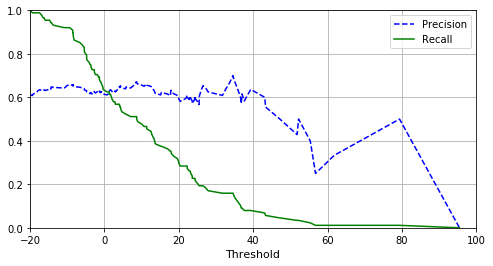

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlim(-20, 100)
    plt.ylim(0, 1)
    plt.grid()
    plt.xlabel('Threshold', fontsize=11)
#%autoreload
#%matplotlib inline

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Standardize inputs

In [21]:
scaled = StandardScaler()
X_train_scld = scaled.fit_transform(X_train.astype(np.float64))

In [22]:
cross_val_score(sgd_clf, X_train_scld, y_train, cv=3, scoring='accuracy') ##decent model improvement

array([0.625     , 0.64814815, 0.7037037 ])

In [23]:
y_train_pred2 = cross_val_predict(sgd_clf, X_train_scld, y_train, cv=3)
confusion_matrix(y_train, y_train_pred2)

array([[53, 23],
       [33, 55]])

In [24]:
train_scores2 = cross_val_predict(sgd_clf, X_train_scld, y_train, cv=3, method="decision_function")

In [25]:
precisions, recalls, thresholds = precision_recall_curve(y_train, train_scores2)

In [26]:
f1_score(y_train, y_train_pred2)

0.6626506024096386

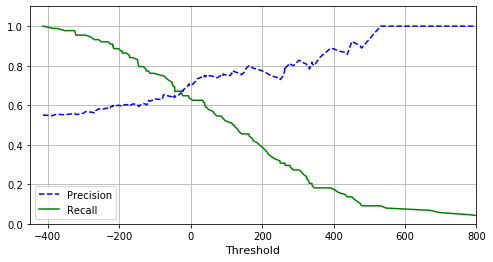

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlim(-450, 800)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.xlabel('Threshold', fontsize=11)
#%autoreload
#%matplotlib inline

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Stratify the kfolds

In [28]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
cross_val_score(sgd_clf, X_train_scld, y_train, cv=kfold, scoring='accuracy') ## improvement with stratification

array([0.76470588, 0.66666667, 0.72727273, 0.71875   , 0.6875    ])

In [30]:
y_train_pred3 = cross_val_predict(sgd_clf, X_train_scld, y_train, cv=kfold)
confusion_matrix(y_train, y_train_pred3)

array([[48, 28],
       [19, 69]])

In [31]:
train_scores3 = cross_val_predict(sgd_clf, X_train_scld, y_train, cv=kfold, method="decision_function")

In [32]:
f1_score(y_train, y_train_pred3) #2*((precision*recall)/(precision+recall))

0.745945945945946

In [33]:
precisions, recalls, thresholds = precision_recall_curve(y_train, train_scores3)

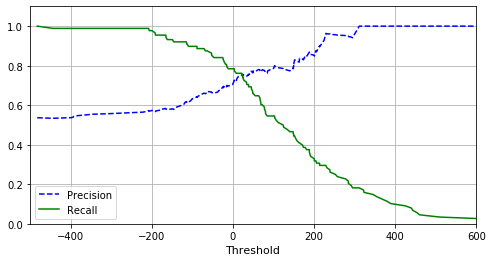

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlim(-500, 600)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.xlabel('Threshold', fontsize=11)
#%autoreload
#%matplotlib inline

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [35]:
fpr, tpr, thresholds = roc_curve(y_train, train_scores3)

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, label=None)
    plt.xlabel('Recall', fontsize=11)
    plt.ylabel('Precision', fontsize=11)


def plot_roc_curve(fpr, tpr, label='ROC'):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.grid()
    plt.legend()# Add axis labels and grid
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('Recall/TPR', fontsize=11)

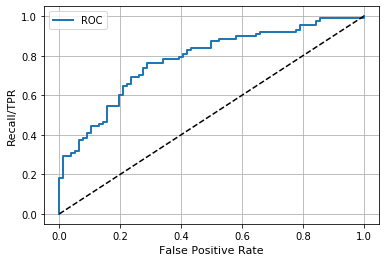

In [37]:
plot_roc_curve(fpr, tpr)
plt.show()

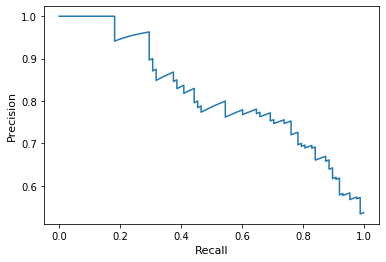

In [38]:
plot_precision_vs_recall(precisions, recalls)

### GridSearch

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate\
              'max_iter': [1000], # number of epochs\
              'loss': ['log', 'hinge'], # logistic regression\
              'penalty': ['l2'],'n_jobs': [-1]}

In [41]:
grid_search = GridSearchCV(sgd_clf, param_grid, cv=kfold, scoring='neg_mean_squared_error', return_train_score=True)

In [42]:
grid_search.fit(X_train_scld, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_...m_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                   1000.0],
                 

In [43]:
grid_search.best_params_

{'alpha': 0.1,
 'loss': 'hinge',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2'}

In [44]:
sgd_clf = grid_search.best_estimator_

In [45]:
cvres = grid_search.cv_results_

In [46]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.563092506371473 {'alpha': 0.0001, 'loss': 'log', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.5353366845767797 {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.5296109939172796 {'alpha': 0.001, 'loss': 'log', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.5179697702828122 {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.5060608273474739 {'alpha': 0.01, 'loss': 'log', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.5296109939172796 {'alpha': 0.01, 'loss': 'hinge', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.48765241519834646 {'alpha': 0.1, 'loss': 'log', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.48135986234123296 {'alpha': 0.1, 'loss': 'hinge', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.5179697702828122 {'alpha': 1.0, 'loss': 'log', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.5 {'alpha': 1.0, 'loss': 'hinge', 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l2'}
0.6246950475

In [47]:
cross_val_score(sgd_clf, X_train_scld, y_train, cv=kfold, scoring='accuracy')

array([0.85294118, 0.75757576, 0.6969697 , 0.75      , 0.78125   ])

In [48]:
y_train_pred4 = cross_val_predict(sgd_clf, X_train_scld, y_train, cv=kfold)
confusion_matrix(y_train, y_train_pred4)

array([[54, 22],
       [16, 72]])

In [49]:
f1_score(y_train, y_train_pred4)

0.7912087912087913

In [50]:
train_scores4 = cross_val_predict(sgd_clf, X_train_scld, y_train, cv=kfold, method="decision_function")

In [51]:
fpr, tpr, thresholds = roc_curve(y_train, train_scores4)

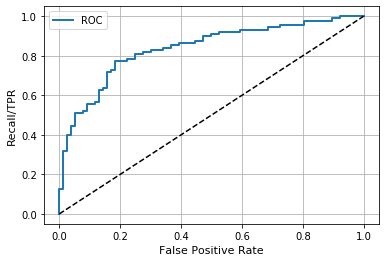

In [52]:
plot_roc_curve(fpr, tpr)
plt.show()

### RandomForest Classifier

In [53]:
rf_clf = RandomForestClassifier(random_state=42)

In [54]:
cross_val_score(rf_clf, X_train_scld, y_train, cv=kfold, scoring='accuracy')

array([0.76470588, 0.75757576, 0.66666667, 0.8125    , 0.75      ])

In [55]:
param_grid = [{'n_estimators':[30,50,100], 'max_features': [8,10,12]}, {'bootstrap':[False], 'n_estimators':[3,10],
                                                                     'max_features':[2,3,4]}]

In [56]:
grid_search = GridSearchCV(rf_clf, param_grid, cv=kfold, scoring='neg_mean_squared_error', return_train_score=True)

In [57]:
grid_search.fit(X_train_scld, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fractio...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
  

In [58]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 30}

In [59]:
cvres = grid_search.cv_results_

In [60]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.42769946138415077 {'max_features': 8, 'n_estimators': 30}
0.4417261042993862 {'max_features': 8, 'n_estimators': 50}
0.4417261042993862 {'max_features': 8, 'n_estimators': 100}
0.4131969352706687 {'max_features': 10, 'n_estimators': 30}
0.42769946138415077 {'max_features': 10, 'n_estimators': 50}
0.4131969352706687 {'max_features': 10, 'n_estimators': 100}
0.4619682176798978 {'max_features': 12, 'n_estimators': 30}
0.43476935292624114 {'max_features': 12, 'n_estimators': 50}
0.43476935292624114 {'max_features': 12, 'n_estimators': 100}
0.5179697702828122 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.47498395351586453 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.5179697702828122 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.4938647983247948 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
0.5120499213467565 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
0.4205107231601626 {'bootstrap': False, 'max_features': 4, 'n_e

In [61]:
rf_clf = grid_search.best_estimator_

In [62]:
cross_val_score(rf_clf, X_train_scld, y_train, cv=kfold, scoring='accuracy')

array([0.79411765, 0.81818182, 0.75757576, 0.90625   , 0.875     ])

In [63]:
y_train_pred5 = cross_val_predict(rf_clf, X_train_scld, y_train, cv=kfold)
confusion_matrix(y_train, y_train_pred5)

array([[61, 15],
       [13, 75]])

In [64]:
train_scores5 = cross_val_predict(rf_clf, X_train_scld, y_train, cv=kfold, method='predict_proba')

In [65]:
train_scores5 = train_scores5[:, 1]

In [66]:
fpr, tpr, thresholds = roc_curve(y_train, train_scores5)

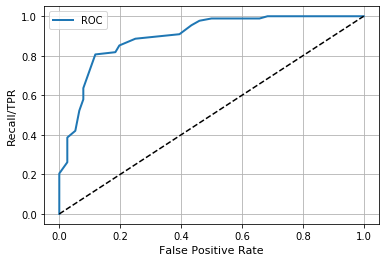

In [67]:
plot_roc_curve(fpr, tpr)
plt.show()

### Develop  Pipeline

In [68]:
from sklearn.pipeline import Pipeline

In [69]:
random_clf = Pipeline([
 ("scaled2", StandardScaler()),
 ("rf_clf2", grid_search.best_estimator_) ##uses previously defined optimized RF model
 ])
random_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaled2',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rf_clf2',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=10, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=30, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [70]:
y_train_pred6 = cross_val_predict(random_clf, X_train_scld, y_train, cv=kfold)
confusion_matrix(y_train, y_train_pred6)

array([[61, 15],
       [13, 75]])

### Build and Train Neural Network

In [72]:
def sigmoid(t):
    return 1/(1+np.exp(-t))

def sigmoid_derivative(p):
    return p * (1 - p)

In [535]:
class NeuralNetwork:
    def __init__(self, x,y):
        self.input = x
        self.weights1= np.random.rand(self.input.shape[1],11) #11 nodes in hidden layer
        self.weights2 = np.random.rand(11,1)
        self.y = y
        self.output = np.zeros(y.shape)
        
    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2))
        return self.layer2
        
    def backprop(self):
        d_weights2 = np.dot(self.layer1.T, 2*(self.y -self.output)*sigmoid_derivative(self.output))
        d_weights1 = np.dot(self.input.T, np.dot(2*(self.y -self.output)*sigmoid_derivative(self.output), self.weights2.T)*sigmoid_derivative(self.layer1))
    
        self.weights1 += d_weights1
        self.weights2 += d_weights2

    def train(self, X, y):
        self.output = self.feedforward()
        self.backprop()                            
                            

In [536]:
y = np.array(y_train, dtype=float).reshape(len(y_train),1) #reshape output dimensions

NN = NeuralNetwork(X_train_scld, y)

In [537]:
loss = []
epochs = []
for i in range(1500):
    loss.append(np.mean(np.square(y - NN.feedforward())))
    epochs.append(i)
    if i % 100==0:
        print ("for iteration # " + str(i) + "\n")
        print ("Input : \n" + str(X_train_scld))
        print ("Actual Output: \n" + str(y))
        print ("Predicted Output: \n" + str(NN.feedforward()))
        print ("Loss: \n" + str(np.mean(np.square(y - NN.feedforward())))) # MSE
        print ("\n")
    NN.train(X_train_scld, y)

for iteration # 0

Input : 
[[-0.41677476 -0.07190072 -0.06298118 ...  0.02098658  0.14464482
  -0.66337588]
 [ 0.62975262  0.36546903  0.97818944 ... -0.51203535 -0.46607775
  -0.43226883]
 [-0.83042195 -0.64738725  0.42624356 ... -0.58818134 -0.6589375
   0.9736324 ]
 ...
 [ 0.09201128 -0.84880753 -0.38913102 ... -0.77093172 -0.30536128
   0.01068635]
 [ 0.91516918  0.11800983 -0.68517471 ...  0.84336327 -0.06428659
  -0.6826348 ]
 [-0.16858645 -0.09492019 -0.79556389 ... -0.71001493 -0.32143293
   0.93511456]]
Actual Output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1

for iteration # 900

Input : 
[[-0.41677476 -0.07190072 -0.06298118 ...  0.02098658  0.14464482
  -0.66337588]
 [ 0.62975262  0.36546903  0.97818944 ... -0.51203535 -0.46607775
  -0.43226883]
 [-0.83042195 -0.64738725  0.42624356 ... -0.58818134 -0.6589375
   0.9736324 ]
 ...
 [ 0.09201128 -0.84880753 -0.38913102 ... -0.77093172 -0.30536128
   0.01068635]
 [ 0.91516918  0.11800983 -0.68517471 ...  0.84336327 -0.06428659
  -0.6826348 ]
 [-0.16858645 -0.09492019 -0.79556389 ... -0.71001493 -0.32143293
   0.93511456]]
Actual Output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 

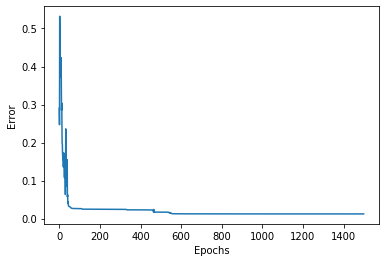

In [538]:
plt.plot(epochs, loss)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()


In [540]:
np.random.rand(X_train_scld.shape[1],11)

array([[0.15931609, 0.47063746, 0.08296057, 0.99906256, 0.47576271,
        0.12161405, 0.7588529 , 0.37440504, 0.04260978, 0.70053363,
        0.67517029],
       [0.77316929, 0.52833342, 0.12531809, 0.5445625 , 0.37737064,
        0.55203144, 0.17654559, 0.72469836, 0.79069146, 0.39161001,
        0.10770498],
       [0.57263865, 0.75075043, 0.58922192, 0.52126157, 0.49284682,
        0.69893689, 0.11288505, 0.00174588, 0.69081463, 0.48576648,
        0.75026712],
       [0.38752018, 0.52925821, 0.10038653, 0.54015214, 0.48687173,
        0.02017332, 0.33506114, 0.51227266, 0.02103549, 0.35089011,
        0.08063358],
       [0.59536832, 0.80034288, 0.07245551, 0.65176496, 0.49003674,
        0.78051624, 0.07608309, 0.8877392 , 0.25203035, 0.39246229,
        0.75852476],
       [0.82185314, 0.46994904, 0.66292046, 0.48628777, 0.58382006,
        0.14621218, 0.3593639 , 0.29479129, 0.54107139, 0.61240164,
        0.73779544],
       [0.31295372, 0.32561142, 0.99693125, 0.21648097, 0.